In [1]:
import sys
sys.path.append('web')

In [2]:
import re
import sqlalchemy as sa
import sqlalchemy.ext.hybrid
import sqlalchemy.ext.declarative as sa_dec
import sqlalchemy_searchable as searchable

from web import models as m
from web.models import *
import web.assessment_models as am
from web.assessment_models import *

In [3]:
import logging

logging.getLogger('sqlalchemy.engine').setLevel(logging.INFO)

In [3]:
engine = sa.create_engine('postgresql+psycopg2://@localhost/tm_navigator', echo=0)
sa.orm.configure_mappers()

In [4]:
Session = sa.orm.sessionmaker(bind=engine)

from contextlib import contextmanager

@contextmanager
def session_scope():
    """Provide a transactional scope around a series of operations."""
    session = Session()
    try:
        yield session
        session.commit()
    except:
        session.rollback()
        raise
    finally:
        session.close()

In [7]:
Base.metadata.create_all(engine)

In [6]:
Base.metadata.drop_all(engine)

In [8]:
conn = engine.raw_connection()
with conn.cursor() as cursor:
    cursor.execute('''
    select tablename
    from pg_tables
    where schemaname = 'public';
    ''')
    tables = [r[0] for r in cursor.fetchall()]
    print('\n'.join(tables))
    if input() == 'y':
        for t in tables:
            print('drop table "%s" cascade;' % t)
            cursor.execute('drop table "%s" cascade' % t)
    cursor.execute('commit')

topics
document_similarities
documents
a_document_similarities
a_topics
topic_edges
document_topics
a_topic_edges
a_document_topics
document_terms
terms
modalities
topic_terms
a_topic_terms



In [9]:
%%file schemadisplay.py
import sqlalchemy as sa
from sqlalchemy_schemadisplay import create_schema_graph

# create the pydot graph object by autoloading all tables via a bound metadata object
graph = create_schema_graph(metadata=sa.MetaData('postgresql+psycopg2://@localhost/tm_navigator'))
graph.write_png('dbschema.png') # write out the file

Overwriting schemadisplay.py


In [10]:
!python2 schemadisplay.py

Couldn't import dot_parser, loading of dot files will not be possible.


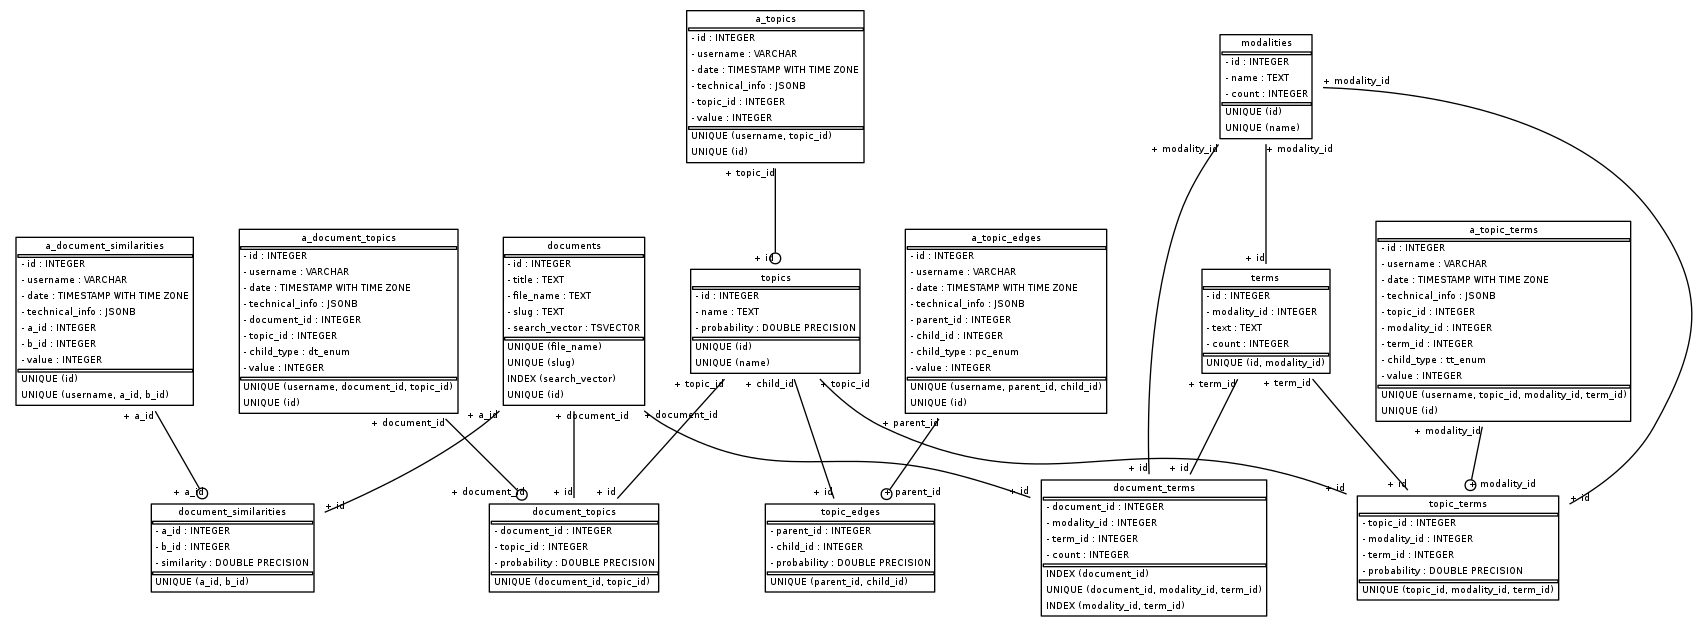

In [11]:
from IPython.display import display, Image

display(Image(filename='dbschema.png'))

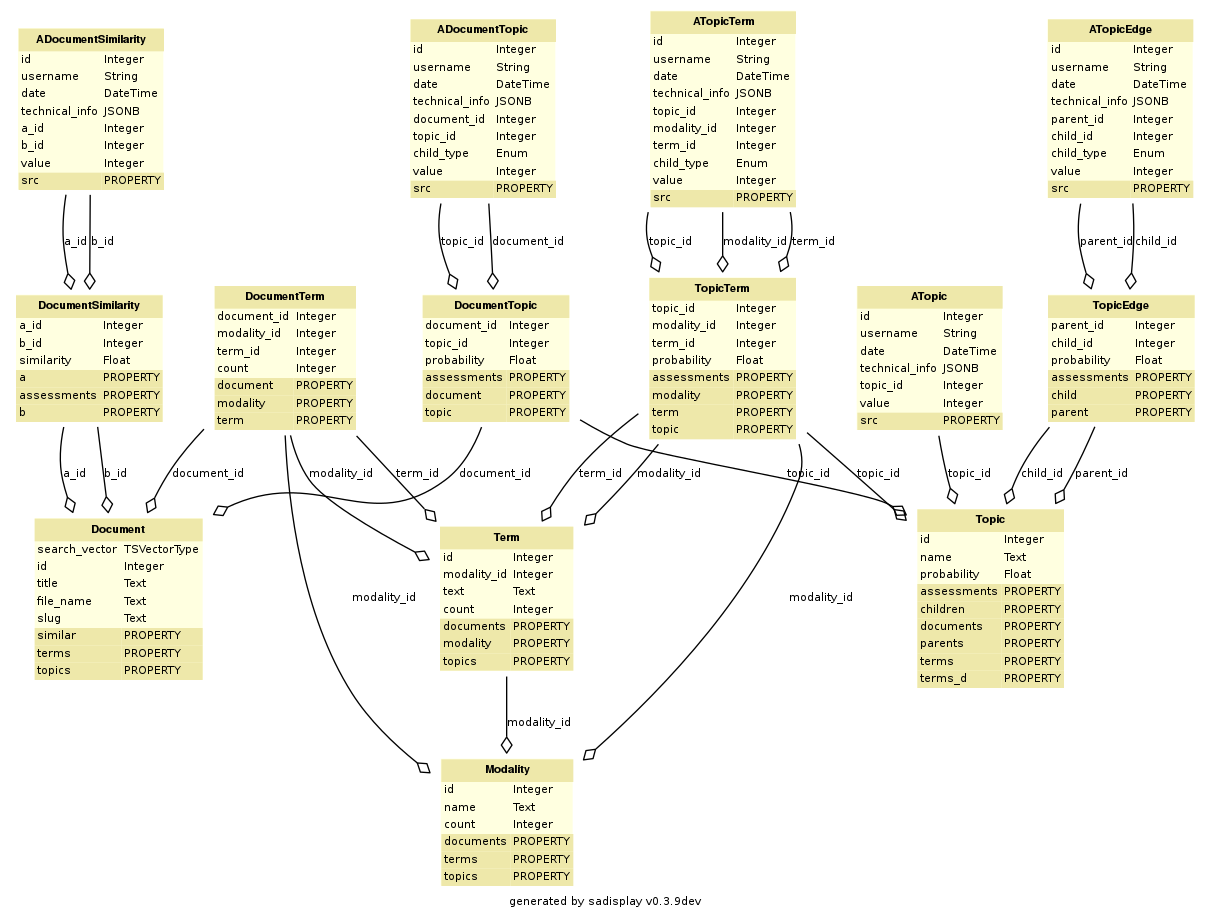

In [20]:
import sadisplay
from IPython.display import display, Image

classes = [c
           for c in Base._decl_class_registry.values()
           if 'Dummy' not in getattr(c, '__name__', 'Dummy')]
desc = sadisplay.describe(classes)
open('dbschema.dot', 'w').write(sadisplay.dot(desc))
!dot -Tpng dbschema.dot > dbschema.png

display(Image(filename='dbschema.png'))

In [12]:
from sqlalchemy_utils import aggregates

aggregates.local_condition = lambda prop, objects: sa.literal(True)

class ListSession(list):
    def execute(self, query):
        print(query)
        return session.execute(query)

def update_aggregates(*classes_modified):
    aggregates.manager.construct_aggregate_queries(
        ListSession([c() for c in classes_modified]),
        None)

In [13]:
import csv
from io import StringIO
from contextlib import closing

def copy_to_table(session, model, rows):
    firstrow = next(rows)
    fieldnames = firstrow.keys()

    with closing(StringIO()) as csv_f:
        writer = csv.DictWriter(csv_f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerow(firstrow)
        writer.writerows(rows)
        csv_f.seek(0)

        with session.connection().connection.cursor() as cursor:
            cursor.copy_expert('copy %s (%s) from stdin with csv header' % (model.__tablename__, ', '.join(fieldnames)), csv_f)
            
    
    update_aggregates(model)

In [14]:
with session_scope() as session:
    session.add(Modality(name='words'))

In [15]:
%%time
with open('nadya_data/dict.txt') as f, session_scope() as session:
    modality = session.query(Modality).filter(Modality.name == 'words').one()
    rows = (dict(id=i, modality_id=modality.id, text=line.strip())
            for i, line in enumerate(f))
#     session.bulk_insert_mappings(Term, rows)
    copy_to_table(session, Term, rows)
    
    print(session.query(Term).count())

UPDATE modalities SET count=(SELECT count(*) AS count_1 
FROM terms 
WHERE modalities.id = terms.modality_id) WHERE :param_1
42682
CPU times: user 356 ms, sys: 24 ms, total: 380 ms
Wall time: 1.51 s


In [16]:
with open('nadya_data/mmro_pdfs/pdfnames.txt') as f:
    fnames = [(int(i), fname)
        for i, fname in (re.match(r'(\d+)\|([\w_/,-]+)\.pdf', line).groups()
                         for line in f)
    ]

with open('nadya_data/mmro_pdfs/titles.txt') as f:
    titles = [(int(i), authors.strip(), title.strip()) for i, authors, title in zip(f, f, f)]
    
assert len(fnames) == len(titles)
assert all(f[0] == t[0] for f, t in zip(fnames, titles))

In [17]:
slugs_seen = set()
slugs = {}
for (_, fname), (id, authors, title) in zip(fnames, titles):
    conf = fname.split('-')[0]
    slug = None
    
    authors = re.findall(r'\w{3,}', authors)
    title_words = re.findall(r'\w{3,}', title)
    
    while not slug or slug in slugs_seen:
        a = authors[0]
        t = title_words.pop(0)
        slug = ('%s_%s_%s' % (a, conf, t)).lower()
    slugs_seen.add(slug)
    slugs[id] = slug

In [18]:
with session_scope() as session:
    rows = (
        dict(id=f[0], title=t[2], file_name=f[1], slug=slugs[f[0]])
        for f, t in zip(fnames, titles)
    )
    copy_to_table(session, Document, rows)
    
    print(session.query(Document).count())

865


In [19]:
with session_scope() as session:
    session.add(Modality(name='authors'))

In [20]:
%%time
with session_scope() as session:
    m = session.query(Modality).filter(Modality.name == 'authors').one()
    
    doc_authors = [(i, author.strip())
     for i, authors, title in titles
     for author in authors.split(',')
    ]
    authors = {a for d, a in doc_authors}
    authors_terms = {a: Term(modality=m, text=a)
                     for a in authors}
    session.add_all(
        DocumentTerm(document_id=d, term=authors_terms[a], count=1)
        for d, a in doc_authors)

CPU times: user 1.1 s, sys: 44 ms, total: 1.15 s
Wall time: 2.61 s


In [21]:
%%time
with session_scope() as session:
    m_id = session.query(Modality.id).filter(Modality.name == 'words').scalar()
    
    with open('nadya_data/ndw.txt') as f:
        D = int(f.readline())
        W = int(f.readline())
        NNZ = int(f.readline())
        print(D, W, NNZ)
        dwn = (map(int, line.split()) for line in f)
        rows = (dict(document_id=d, modality_id=m_id, term_id=w, count=n)
                for d, w, n in dwn)

        copy_to_table(session, DocumentTerm, rows)
    
    print(session.query(DocumentTerm.modality_id, sa.func.count()).group_by(DocumentTerm.modality_id).all())

865 42683 -1
UPDATE terms SET count=(SELECT coalesce(sum(document_terms.count), :param_1) AS coalesce_1 
FROM document_terms 
WHERE terms.modality_id = document_terms.modality_id AND terms.id = document_terms.term_id) WHERE :param_2
[(2, 1892), (1, 190079)]
CPU times: user 1.48 s, sys: 12 ms, total: 1.49 s
Wall time: 18.3 s


In [23]:
import pickle

with open('nadya_data/3level_2907_alt_levels_dict.dump', 'rb') as f:
    matrices = pickle.loads(f.read().replace(b'\r\n', b'\n'), encoding='latin1')

In [24]:
%%time

with session_scope() as session:
    m_id = session.query(Modality.id).filter(Modality.name == 'words').scalar()
    
    session.add(Topic(id=0))

    for (level, mat_name), matrix in sorted(matrices.items()):
        matrix = matrix.tocoo()
        t_to_id = lambda t: (level + 1) * 1000 + t
        
        if mat_name == 'phi':
            copy_to_table(session, Topic,
                          (dict(id=t_to_id(t))
                           for t in range(matrix.shape[1])
                          ))

            rows = (dict(topic_id=t_to_id(int(t)), modality_id=m_id, term_id=int(w), probability=float(val))
                    for w, t, val in zip(matrix.row, matrix.col, matrix.data))
            copy_to_table(session, TopicTerm, rows)
        elif mat_name == 'theta':
            rows = (dict(topic_id=t_to_id(int(t)), document_id=int(d), probability=float(val))
                    for t, d, val in zip(matrix.row, matrix.col, matrix.data))
            copy_to_table(session, DocumentTopic, rows)
        else:
            raise
            
    
    print(session.query(Topic.level, sa.func.count()).group_by(Topic.level).all())
    print(session.query(Topic.level, sa.func.count()).join(DocumentTopic).group_by(Topic.level).all())
    print(session.query(Topic.level, sa.func.count()).join(TopicTerm).group_by(Topic.level).all())

UPDATE topics SET probability=(SELECT coalesce(sum(document_topics.probability), :param_1) AS coalesce_1 
FROM document_topics 
WHERE topics.id = document_topics.topic_id) WHERE :param_2
UPDATE topics SET probability=(SELECT coalesce(sum(document_topics.probability), :param_1) AS coalesce_1 
FROM document_topics 
WHERE topics.id = document_topics.topic_id) WHERE :param_2
UPDATE topics SET probability=(SELECT coalesce(sum(document_topics.probability), :param_1) AS coalesce_1 
FROM document_topics 
WHERE topics.id = document_topics.topic_id) WHERE :param_2
[(0, 1), (2, 32), (1, 11), (3, 62)]
[(2, 3429), (1, 9335), (3, 3247)]
[(2, 79821), (1, 85221), (3, 74167)]
CPU times: user 2.32 s, sys: 64 ms, total: 2.38 s
Wall time: 21.4 s


In [25]:
%%time
import numpy as np
from scipy.spatial.distance import pdist, squareform

with session_scope() as session:
    vectors = session.query(Document.id,
                      sa.func.array_agg(sa.func.coalesce(DocumentTopic.probability, 0), order_by=Topic.id))\
        .select_from(Topic).join(Document, sa.literal(True))\
        .outerjoin(DocumentTopic, sa.and_(Topic.documents, Document.topics))\
        .group_by(Document.id)\
        .order_by(Document.id)\
        .all()
    theta = [v for _, v in vectors]
    theta = np.array(theta)
    distances = squareform(pdist(theta, 'cosine'))        

    rows = (dict(a_id=i, b_id=sim_i, similarity=1 - row[sim_i])
            for i, row in enumerate(distances)
            for sim_i in row.argsort()[:31]
            if sim_i != i)
    copy_to_table(session, DocumentSimilarity, rows)

CPU times: user 556 ms, sys: 4 ms, total: 560 ms
Wall time: 2.05 s


In [26]:
id_from_nadya = lambda s: sum(mul * int(val)
                              for mul, val in zip([1000, 1], re.findall('\d+', s)))

with session_scope() as session, \
     open('nadya_data/alt2907_3levels_hierarchy_edges.csv') as f:
    reader = csv.DictReader(f, fieldnames=['parent', 'child', 'probability'], delimiter=';')
    edges = ({'parent_id': id_from_nadya(row['parent']),
              'child_id': id_from_nadya(row['child']),
              'probability': float(row['probability'])}
             for row in reader)

    copy_to_table(session, TopicEdge, edges)

In [121]:
with session_scope() as session:
#     session.query(Term).\
#         update({Term.count:
#                 session.query(sa.sql.functions.coalesce(sa.func.sum(DocumentTerm.count), 0)).\
#                 filter_by(term_id=Term.id, modality_id=Term.modality_id).\
#                 subquery().as_scalar()},
#                synchronize_session=False)
    session.execute('''
    with counts as (
        select modality_id, term_id, sum(count)
        from document_terms
        group by modality_id, term_id
    )
    
    update terms
    set count = counts.sum
    from counts
    where counts.term_id = terms.id and counts.modality_id = terms.modality_id
    ''')
#     print session.query(Term.count == sa.func.sum(DocumentTerm.count)).join(DocumentTerm).group_by(Term).all()

In [27]:
with session_scope() as session:
    session.execute('''
    with probs as (
        select
            topic_id,
            sum(probability / (select count(*) from documents)) as probability
        from document_topics
        group by topic_id
    )
    
    update topics
    set probability = probs.probability
    from probs
    where topics.id = probs.topic_id
    ''')
    print(session.query(Topic.level, sa.func.sum(Topic.probability)).group_by(Topic.level).all())

[(0, 0.0), (2, 0.999999999999498), (1, 0.999999999999493), (3, 0.99999999999952)]


In [11]:
import sqlalchemy_utils

In [12]:
for k, v in sorted(sqlalchemy_utils.functions.non_indexed_foreign_keys(Base.metadata, engine).items()):
    print(k, ':', [fk.name for fk in v])

NoSuchTableError: dummy_table_918629a2-6e30-4e2d-93a3-5541b9a2ca93

In [25]:
'-'*10000

'---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------